Import necessary modules

In [ ]:
import os
import tensorflow as tf

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt

import numpy as np
import PIL.Image
import time
import functools

Choosing a style image and a content image:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
content_path="/content/drive/MyDrive/car.jpg"
style_path="/content/drive/MyDrive/starry_night.jpg"

Preprocess image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path):
  max_dim = 512
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3)

  #scale pixel vales in the range [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Visualize the input images

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

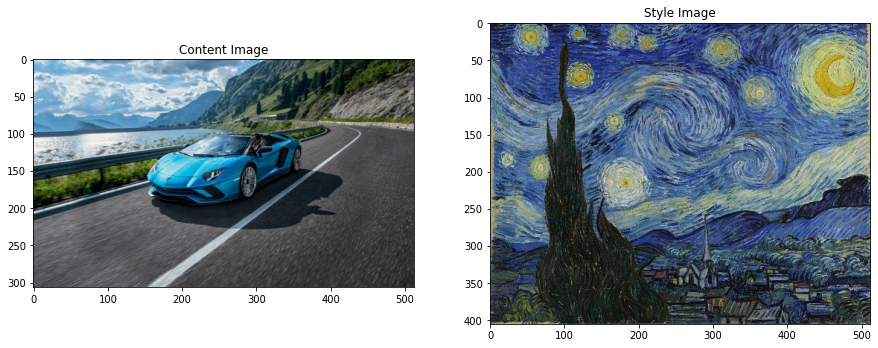

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Load VGG19 Model

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

#the layers in VGG19
print("\n",len(vgg.layers),"\n")
for layer in vgg.layers:
  if 'conv' not in layer.name:
    print(layer.name)
    continue
  filters,bias=layer.get_weights()
  print(layer.name,filters.shape,filters.min(),filters.max())

80134624/80134624 [==============================] - 0s 0us/step

 22 

input_1
block1_conv1 (3, 3, 3, 64) -0.6509952 0.55092514
block1_conv2 (3, 3, 64, 64) -0.21275842 0.24482273
block1_pool
block2_conv1 (3, 3, 64, 128) -0.33745438 0.42179304
block2_conv2 (3, 3, 128, 128) -0.18757026 0.24339235
block2_pool
block3_conv1 (3, 3, 128, 256) -0.17238086 0.59454405
block3_conv2 (3, 3, 256, 256) -0.14607364 0.5518415
block3_conv3 (3, 3, 256, 256) -0.085466735 0.21768856
block3_conv4 (3, 3, 256, 256) -0.09941815 0.23780958
block3_pool
block4_conv1 (3, 3, 256, 512) -0.110317715 0.2555693
block4_conv2 (3, 3, 512, 512) -0.11221807 0.38975286
block4_conv3 (3, 3, 512, 512) -0.09207472 0.2962988
block4_conv4 (3, 3, 512, 512) -0.13553025 0.22220805
block4_pool
block5_conv1 (3, 3, 512, 512) -0.11946911 0.33888996
block5_conv2 (3, 3, 512, 512) -0.11451616 0.3534059
block5_conv3 (3, 3, 512, 512) -0.12495919 0.26290247
block5_conv4 (3, 3, 512, 512) -0.11371553 0.17125924
block5_pool


We use certain intermediate layers of the model to extract content and style from the image

Complex features are extracted in the final layers. So to get content from the image we use higher layer block5_conv2 from the model

In a CNN model, new features are learnt in each layer. Horizontal and vertical edge in the first, corners in the second, and so on. Hence to extract style, we use multiple layers (one from each block)

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block3_conv1',  
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Build a VGG Model to return intermediate output for specified layers

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  674.30426
  mean:  24.266891

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7760.456
  mean:  144.84634

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3916.5886
  mean:  49.132156



Define the gram matrix to extract style

Gram matrix represents the correlation between all channels of a layer with each other

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.01350371
    max:  14514.395
    mean:  557.1017

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  446130.16
    mean:  16104.34

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110758.695
    mean:  1648.0043

Contents:
   block5_conv2
    shape:  (1, 19, 32, 512)
    min:  0.0
    max:  1615.8201
    mean:  15.248603


## Run gradient descent

Set style and content target values:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Generated image

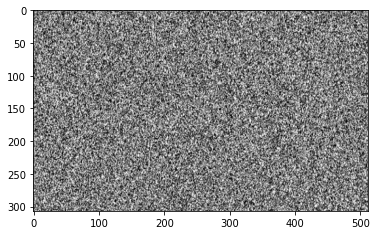

In [ ]:
imgpath='/content/drive/MyDrive/noise.jpg'
image=load_img(imgpath)

image=tf.image.resize(image,content_image.shape[1:3])
imshow(image)
image=tf.Variable(image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
def style_content_loss(outputs):
    style_weight=1e-1
    content_weight=1e4

    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

....................................................................................................
Train step: 100
Loss after epoch (MSE)  1 :  18001224
....................................................................................................
Train step: 200
Loss after epoch (MSE)  2 :  6013277
....................................................................................................
Train step: 300
Loss after epoch (MSE)  3 :  2798366
....................................................................................................
Train step: 400
Loss after epoch (MSE)  4 :  1702955
....................................................................................................
Train step: 500
Loss after epoch (MSE)  5 :  1246660
....................................................................................................
Train step: 600
Loss after epoch (MSE)  6 :  1021406
...........................................................................

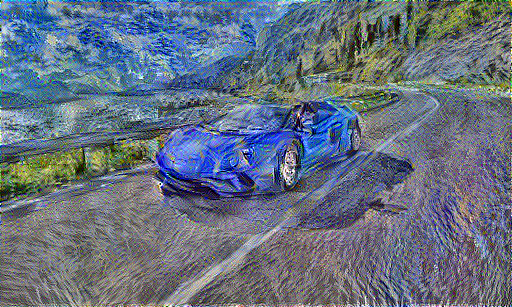


Total time: 54.4 s
Final Loss (MSE):  740354


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  print("\nTrain step: {}".format(step))
  print("Loss after epoch (MSE) ",n+1,": ",int(style_content_loss(extractor(image))))


end = time.time()
display.display(tensor_to_image(image))
print("\nTotal time: {:.1f} s".format(end-start))
print("Final Loss (MSE): ",int(style_content_loss(extractor(image))))

Test with a set of 10 images:

In [ ]:
tf.config.run_functions_eagerly(True)


Image 1 :


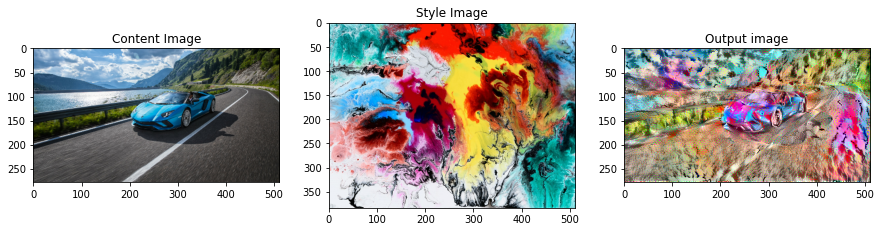


Total time: 46.3 s
Final Loss (MSE):  2695649
Image 2 :


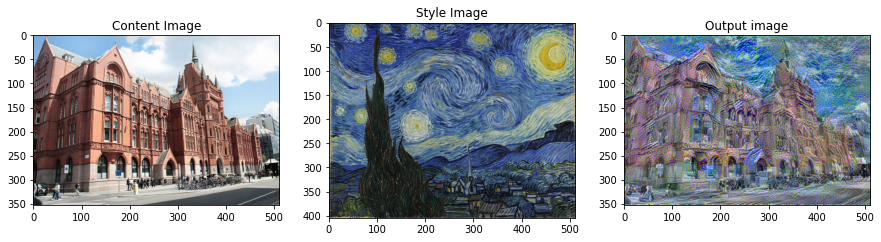


Total time: 56.5 s
Final Loss (MSE):  3398983
Image 3 :


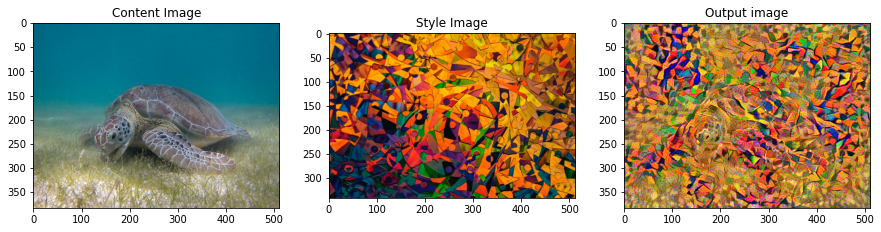


Total time: 60.8 s
Final Loss (MSE):  4126239
Image 4 :


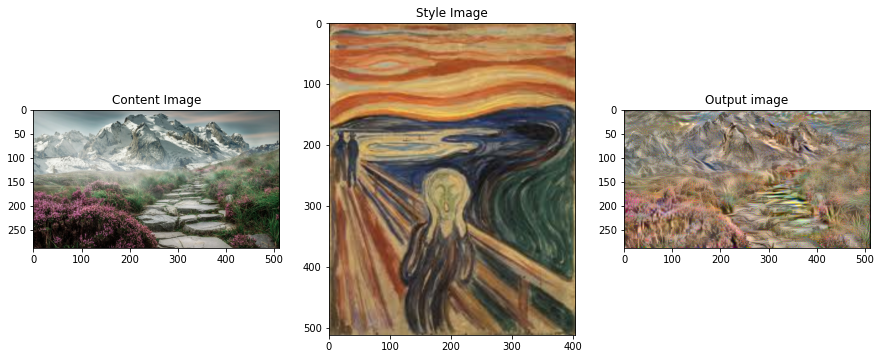


Total time: 48.7 s
Final Loss (MSE):  2088794
Image 5 :


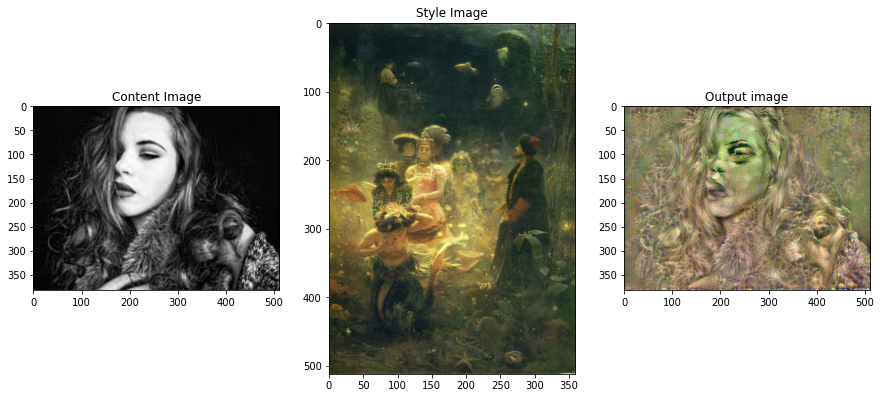


Total time: 61.8 s
Final Loss (MSE):  1102338
Image 6 :


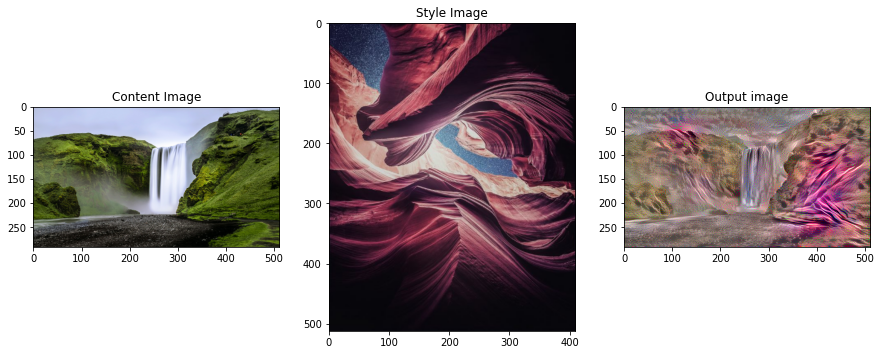


Total time: 49.6 s
Final Loss (MSE):  2194769
Image 7 :


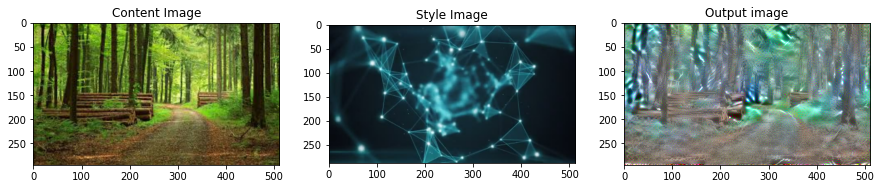


Total time: 49.5 s
Final Loss (MSE):  2988092
Image 8 :


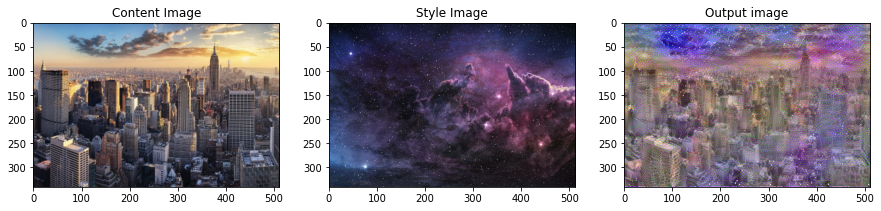


Total time: 57.1 s
Final Loss (MSE):  2251605
Image 9 :


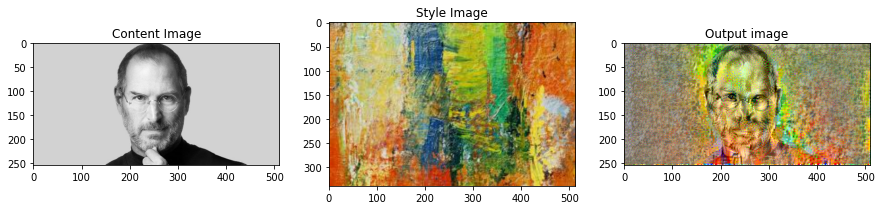


Total time: 45.1 s
Final Loss (MSE):  1064436
Image 10 :


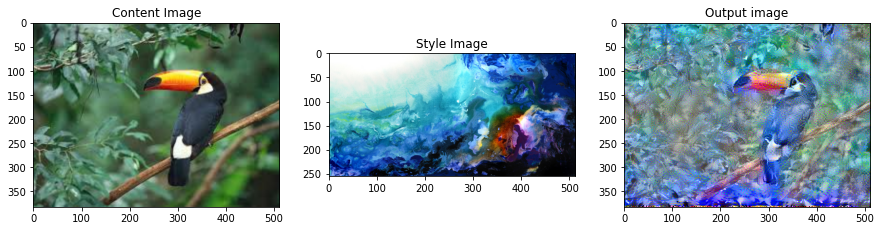


Total time: 60.8 s
Final Loss (MSE):  1528151


In [ ]:
t=[]
l=[]

for i in range(10):
  print("Image",i+1,":")
  content_path="/content/drive/MyDrive/NST_IMAGES/content_"+str(i+1)+".jpg"
  style_path="/content/drive/MyDrive/NST_IMAGES/style_"+str(i+1)+".jpg"

  content_image=load_img(content_path)
  style_image=load_img(style_path)

  plt.figure(figsize=(15,15))
  plt.subplot(1, 3, 1)
  imshow(content_image, 'Content Image')

  plt.subplot(1, 3, 2)
  imshow(style_image, 'Style Image')

  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']

  imgpath='/content/drive/MyDrive/noise.jpg'
  image=load_img(imgpath)

  image=tf.image.resize(image,content_image.shape[1:3])
  image = tf.Variable(image)

  start = time.time()

  epochs = 5
  steps_per_epoch = 100

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
  end = time.time()

  plt.subplot(1,3,3)
  imshow(image,'Output image')
  plt.show()

  print("\nTotal time: {:.1f} s".format(end-start))
  t.append(end-start)
  lo=int(style_content_loss(extractor(image)))
  print("Final Loss (MSE): ",lo)
  l.append(lo)


In [ ]:
avg_time=sum(t)/len(t)
print("Average time taken to transfer: %.2f s"%avg_time)

Average time taken to transfer: 53.64 s


In [ ]:
avg_loss=sum(l)/len(l)
print("Average loss after 5 epochs: ",int(avg_loss))

Average loss after 5 epochs:  2343905


# **NST with 2 style images**

In [ ]:
content_path="/content/drive/MyDrive/NST_IMAGES/content_8.jpg"
style_path1="/content/drive/MyDrive/NST_IMAGES/style_8.jpg"
style_path2="/content/drive/MyDrive/NST_IMAGES/style_1.jpg"

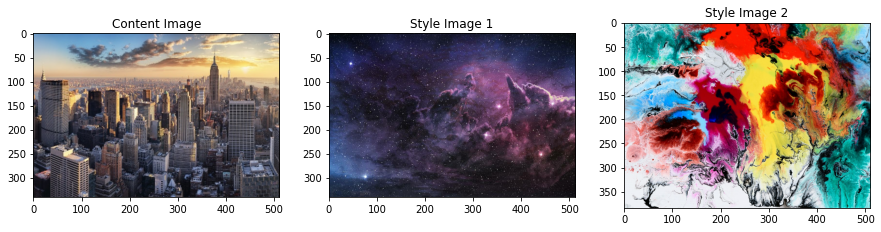

In [ ]:
content_image = load_img(content_path)
style_image1 = load_img(style_path1)
style_image2=load_img(style_path2)

plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image1, 'Style Image 1')

plt.subplot(1,3,3)
imshow(style_image2,'Style Image 2')

In [ ]:
style_targets1 = extractor(style_image1)['style']
style_targets2 = extractor(style_image2)['style']
content_targets = extractor(content_image)['content']

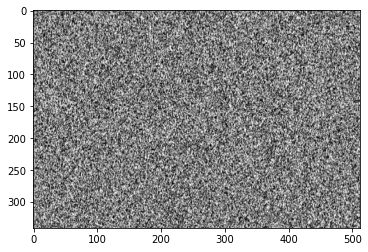

In [ ]:
imgpath='/content/drive/MyDrive/noise.jpg'
image=load_img(imgpath)

image=tf.image.resize(image,content_image.shape[1:3])
imshow(image)
image=tf.Variable(image)

In [ ]:
def style_content_loss2(outputs):
    style_weight1,style_weight2=1e-1,1e-1
    content_weight=1e4

    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss1 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets1[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss1 *= style_weight1 / num_style_layers

    style_loss2 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets2[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss2 *= style_weight2 / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss1 + style_loss2 + content_loss
    return loss

In [ ]:
@tf.function()
def train_step2(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss2(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

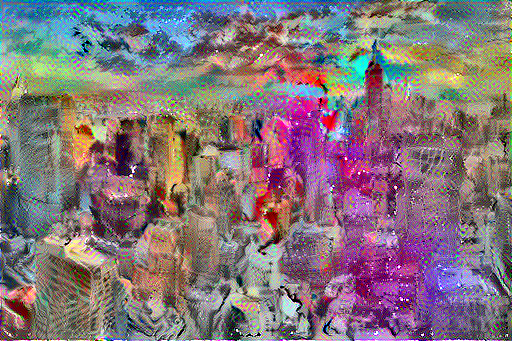

Train step: 1000
Total time: 110.7 s
Final loss:  38931220


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step2(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f} s".format(end-start))
print("Final loss: ",int(style_content_loss2(extractor(image))))